# Topic Modelling on Customer Review with Latent Dirichlet Allocation Model: The case of UK Delivery Companies

In [1]:
import os
import pandas as pd

project_dir = r'D:\GitHub\Projects\Analysis_of_Delivery_Companies_Reviews'
os.chdir(project_dir)

In [2]:
from helpers.utilities import splitRatingsColumn
from processing import text_processing as tp
from texteda import (most_common_words,
                     plot_most_common_words,
                     plot_wordcloud,
                     compute_bigrams,
                     plot_bigrams)

from nltk.corpus import stopwords

In [3]:
processed_pages_file = os.path.join(project_dir, 'processed_pages.txt')
reviews_base_file = os.path.join(project_dir, 'reviews.csv')


In [4]:
col_names = ['Company', 'Id', 'Reviewer_Id', 'Title', 'Review', 'Date', 'Rating']
ratings_dict = {1: 'Bad', 2: 'Poor', 3: 'Average', 4: 'Great', 5: 'Excellent'}      

base_df = pd.read_csv(reviews_base_file, sep=',')

In [5]:
base_df.head()

,Company,Id,Reviewer_Id,Title,Review,Date,Rating
0,Deliveroo,60709f95f85d75087052ff8b,60709f8f0a30fd001b06dc52,Ordered food and apparently the driver…,Ordered food and apparently the driver was wai...,2021-04-09 18:40,{2: 'Poor'}
1,Deliveroo,60708710f85d75087052c89b,6070870c2158190019b3ab8e,Disgusting Live Customer Service CHAT!!!,I received standard bag of buttons that cost £...,2021-04-09 16:55,{1: 'Bad'}
2,Deliveroo,60707b91f85d75087052abb6,602eb3ac49aeca0019ad4b70,Just had an appalling experience with…,Just had an appalling experience with delivero...,2021-04-09 16:06,{1: 'Bad'}
3,Deliveroo,60705919f85d7508705251d4,60705856348d93001ad1ca1f,The same situation happened twice,The same situation happened twice. I ordered f...,2021-04-09 13:39,{2: 'Poor'}
4,Deliveroo,60705138f85d750870523d4d,6070512519dc76001aebe4b1,Driver left without giving us food,Driver turned up late couldn’t find us and lef...,2021-04-09 13:06,{1: 'Bad'}


In [6]:
stopwords_ls = stopwords.words('english')
stopwords_ls.extend(['\'d', '\'m', '\'s', '\'ve', '\'re', '\'ll', 'n\'t', '’'])

common_delivery_words = ['delivery', 'deliver', 'driver', 'order', 'uber', 'stuart', 'deliveroo']
stopwords_ls.extend(common_delivery_words)

In [7]:

# See a distribution of number of reviews among all companies
base_df['Company'].value_counts()

UberEats     7840
Deliveroo    5760
JustEat      1840
Stuart        160
Name: Company, dtype: int64

In [8]:
# Check for duplicates
base_df.drop_duplicates(inplace=True)

In [9]:
# Cast columns specific data format
base_df['Date'] = pd.to_datetime(base_df['Date'], format="%Y-%m-%d %H:%M", errors='coerce')
base_df['Rating'] = base_df['Rating'].apply(lambda row: splitRatingsColumn(row)[0]).astype(int)
base_df['Rating_Text'] = base_df['Rating'].apply(lambda row: ratings_dict[row])


In [10]:
# Transform dataset

# Delete rows where the review is empty
base_df = base_df[base_df['Review'].notna()]

# Split review in tokens and remove punctuation, stopwords
base_df['Review_Clean'] = base_df['Review'].apply(lambda row: tp.tokenize_and_clean(text=row, stopwords_ls=stopwords_ls))

# Lemmatize the tokens
base_df['Review_Lemma'] = base_df['Review_Clean'].apply(lambda row: tp.lemmatize(text=row, pos_type='n'))


base_df['Review_Merged'] = base_df['Review_Lemma'].apply(lambda row: ' '.join([x for x in row]))


In [11]:
base_df.head(10)

,Company,Id,Reviewer_Id,Title,Review,Date,Rating,Rating_Text,Review_Clean,Review_Lemma,Review_Merged
0,Deliveroo,60709f95f85d75087052ff8b,60709f8f0a30fd001b06dc52,Ordered food and apparently the driver…,Ordered food and apparently the driver was wai...,2021-04-09 18:40:00,2,Poor,"[ordered, food, apparently, waiting, mins, foo...","[ordered, food, apparently, waiting, min, food...",ordered food apparently waiting min food even ...
1,Deliveroo,60708710f85d75087052c89b,6070870c2158190019b3ab8e,Disgusting Live Customer Service CHAT!!!,I received standard bag of buttons that cost £...,2021-04-09 16:55:00,1,Bad,"[received, standard, bag, buttons, cost, £1.60...","[received, standard, bag, button, cost, £1.60,...",received standard bag button cost £1.60 asked ...
2,Deliveroo,60707b91f85d75087052abb6,602eb3ac49aeca0019ad4b70,Just had an appalling experience with…,Just had an appalling experience with delivero...,2021-04-09 16:06:00,1,Bad,"[appalling, experience, ordered, pizza, £10, d...","[appalling, experience, ordered, pizza, £10, d...",appalling experience ordered pizza £10 discoun...
3,Deliveroo,60705919f85d7508705251d4,60705856348d93001ad1ca1f,The same situation happened twice,The same situation happened twice. I ordered f...,2021-04-09 13:39:00,2,Poor,"[situation, happened, twice, ordered, food, ar...","[situation, happened, twice, ordered, food, ar...",situation happened twice ordered food around p...
4,Deliveroo,60705138f85d750870523d4d,6070512519dc76001aebe4b1,Driver left without giving us food,Driver turned up late couldn’t find us and lef...,2021-04-09 13:06:00,1,Bad,"[turned, late, find, us, left, awful]","[turned, late, find, u, left, awful]",turned late find u left awful
5,Deliveroo,60701fb8f85d75087051b618,5fcf534133b62e00194147a9,Wish Icould give it zero stars,Wish Icould give it zero stars. Customers serv...,2021-04-09 09:34:00,1,Bad,"[wish, icould, give, zero, stars, customers, s...","[wish, icould, give, zero, star, customer, ser...",wish icould give zero star customer service ac...
6,Deliveroo,606f6220f85d75087050df29,606f621b252e9400195d0279,Once again we placed an order,Once again we placed an order - paid Deliveroo...,2021-04-08 20:05:00,1,Bad,"[placed, paid, premium, time, 8.35, drivers, w...","[placed, paid, premium, time, 8.35, driver, wa...",placed paid premium time 8.35 driver waiting r...
7,Deliveroo,606ed6abf85d7508704f5b9c,529cb994000064000157b639,Deliveroo rider stole from me,Deliveroo rider stole from me on his way out o...,2021-04-08 10:10:00,1,Bad,"[rider, stole, way, building, customer, servic...","[rider, stole, way, building, customer, servic...",rider stole way building customer service effe...
8,Deliveroo,606e15cef85d7508704e7ee8,551017660000ff0001b3597e,Useless service,Useless service. I live 5 mins from store and ...,2021-04-07 20:27:00,1,Bad,"[useless, service, live, mins, store, find, ad...","[useless, service, live, min, store, find, add...",useless service live min store find address to...
9,Deliveroo,606dfc12f85d7508704e45f5,606dfc0dc80f69001ac5410f,Do not use this app,Do not use this app! There t and c protect dri...,2021-04-07 18:38:00,1,Bad,"[use, app, c, protect, theft, receive, entitle...","[use, app, c, protect, theft, receive, entitle...",use app c protect theft receive entitled refun...


In [12]:
# Exploratory Data Analysis
most_common_words(base_df, text_col='Review_Merged', n_most_common=10)


,words,count
0,food,7266
1,service,7058
2,customer,5467
3,time,5126
4,refund,4828
5,never,4530
6,ordered,4077
7,get,3959
8,use,3742
9,restaurant,3452


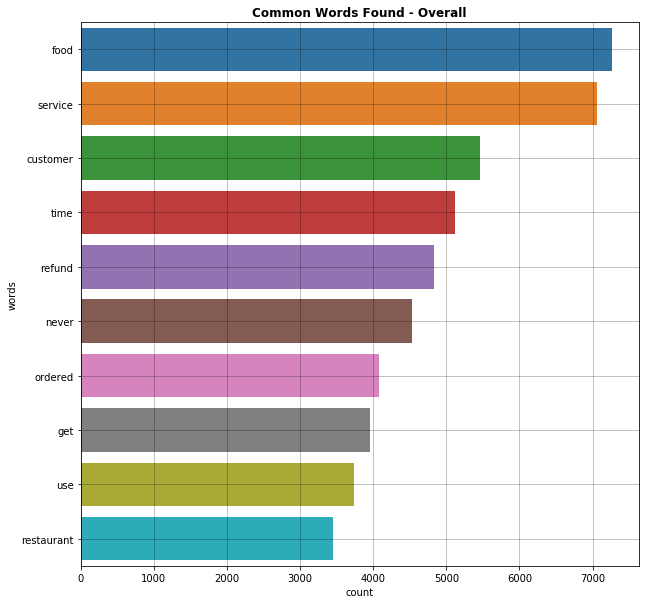

In [13]:
plot_most_common_words(base_df,  n_most_common=10, text_col='Review_Merged')
